In [23]:
import pandas as pd
import numpy as np
import joblib



In [24]:
# Load your dataset (assuming it has the protected attribute and true labels)
data = pd.read_csv("../data/dataproject2025.csv")  # replace with your actual dataset path

# Load predicted probabilities
pred_probs = joblib.load("../models/predicted_probabilities.pkl")  # replace path if needed




In [25]:


# Load original full dataset with 'Pct_afro_american' and 'issue_date'
full_data = pd.read_csv("../data/dataproject2025.csv", parse_dates=['issue_d'])

# Filter for test period (2019-2020)
test_data = full_data[(full_data['issue_d'].dt.year >= 2019) & 
                             (full_data['issue_d'].dt.year <= 2020)]

# Keep only needed columns: protected attribute + maybe ID if exists
protected_info = test_data[['Pct_afro_american']]  # add 'id' if needed


In [26]:
# Load your pickle with test variables
dict_var = joblib.load("../models/needed_variables.pkl")
X_test = dict_var['X_test']
y_test = dict_var['y_test']
y_pred_test = dict_var['y_pred_test']
y_proba = dict_var['y_proba']

# Create dataframe for analysis
data = X_test.copy()
data['target'] = y_test
data['pred_prob'] = y_proba
data['pred_label'] = y_pred_test


In [27]:
# Add protected attribute
data['Pct_afro_american'] = protected_info['Pct_afro_american'].values


In [28]:
protected_col = 'Pct_afro_american'

# Median split
median_pct = data[protected_col].median()
data['group'] = np.where(data[protected_col] >= median_pct, 'high_afro', 'low_afro')

# Predicted Positive Rate (PPR)
ppr = data.groupby('group')['pred_prob'].mean()
spd = ppr['high_afro'] - ppr['low_afro']
di = ppr['high_afro'] / ppr['low_afro']

# TPR / TNR
tpr = data[data['target']==1].groupby('group')['pred_label'].mean()
tnr = data[data['target']==0].groupby('group')['pred_label'].apply(lambda x: (x==0).mean())

print("PPR by group:\n", ppr)
print("SPD:", spd)
print("DI:", di)
print("TPR by group:\n", tpr)
print("TNR by group:\n", tnr)


PPR by group:
 group
high_afro    0.391949
low_afro     0.378975
Name: pred_prob, dtype: float64
SPD: 0.012974690174163306
DI: 1.0342362969850827
TPR by group:
 group
high_afro    0.520544
low_afro     0.517162
Name: pred_label, dtype: float64
TNR by group:
 group
high_afro    0.754862
low_afro     0.772079
Name: pred_label, dtype: float64


C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\2019180023.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\2019180023.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdp = data.groupby('bin')['pred_prob'].mean()


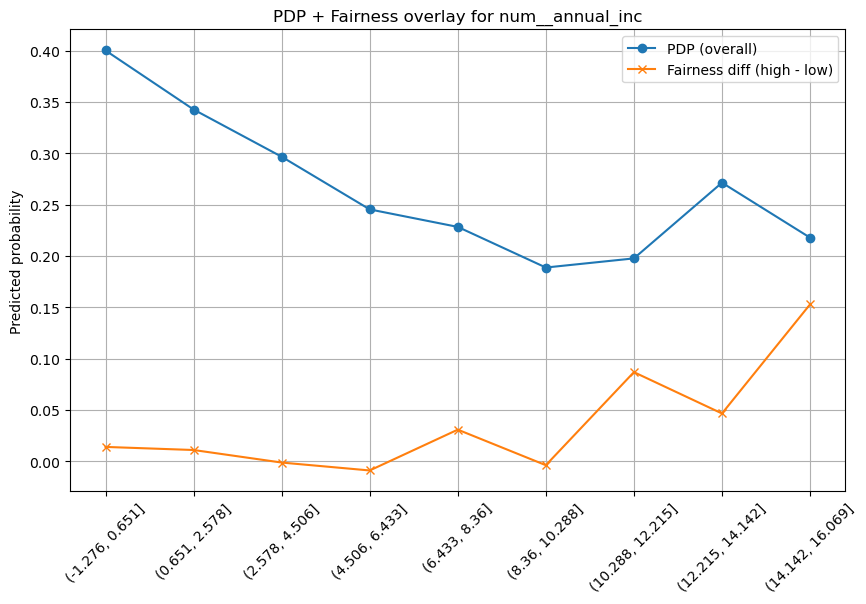

In [29]:
import matplotlib.pyplot as plt

feature = 'num__annual_inc'  # or any other numeric feature
bins = np.linspace(data[feature].min(), data[feature].max(), 10)
data['bin'] = pd.cut(data[feature], bins)

# Compute mean predictions per group per bin
bin_stats = data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
bin_stats['fairness_diff'] = bin_stats['high_afro'] - bin_stats['low_afro']

plt.figure(figsize=(10,6))
# PDP (overall)
pdp = data.groupby('bin')['pred_prob'].mean()
plt.plot(pdp.index.astype(str), pdp.values, marker='o', label='PDP (overall)')

# FPDP (fairness)
plt.plot(bin_stats.index.astype(str), bin_stats['fairness_diff'], marker='x', label='Fairness diff (high - low)')

plt.xticks(rotation=45)
plt.ylabel("Predicted probability")
plt.title(f"PDP + Fairness overlay for {feature}")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
test_data['target'] = y_test
test_data['pred_label'] = y_pred_test
test_data['pred_prob'] = y_proba

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['target'] = y_test
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_label'] = y_pred_test
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3931272184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [31]:
# Median split for fairness
median_pct = test_data['Pct_afro_american'].median()
test_data['group'] = np.where(test_data['Pct_afro_american'] >= median_pct, 'high_afro', 'low_afro')


C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3015561627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['group'] = np.where(test_data['Pct_afro_american'] >= median_pct, 'high_afro', 'low_afro')


C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\2393399738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['bin'] = bins
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\2393399738.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = test_data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\2393399738.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

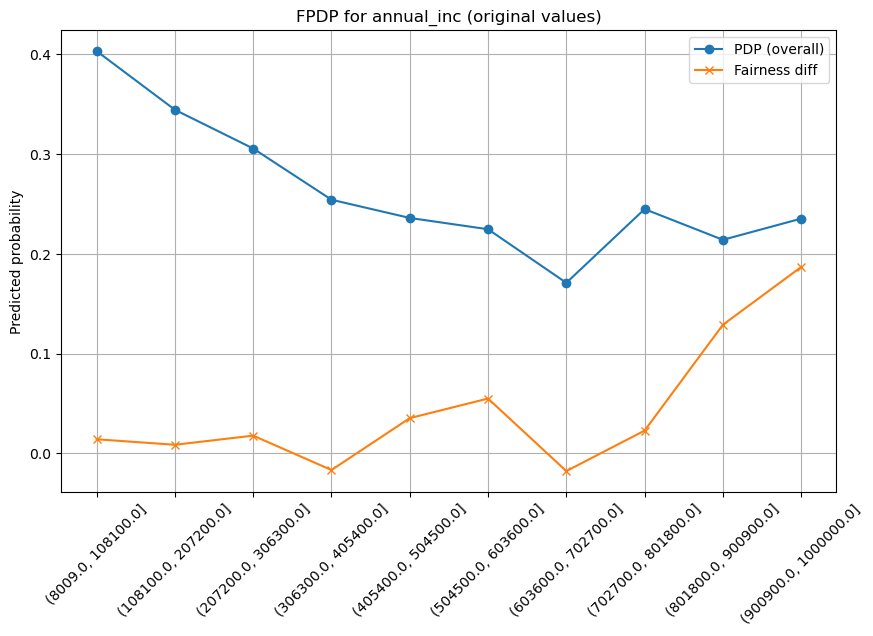

In [32]:
# FPDP
bins = pd.cut(test_data['annual_inc'], bins=10)
test_data['bin'] = bins

bin_stats = test_data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
bin_stats['fairness_diff'] = bin_stats['high_afro'] - bin_stats['low_afro']

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
pdp = test_data.groupby('bin')['pred_prob'].mean()
plt.plot(pdp.index.astype(str), pdp.values, marker='o', label='PDP (overall)')
plt.plot(bin_stats.index.astype(str), bin_stats['fairness_diff'], marker='x', label='Fairness diff')
plt.xticks(rotation=45)
plt.ylabel("Predicted probability")
plt.title("FPDP for annual_inc (original values)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
def plot_fpdp(data, feature, protected_col='Pct_afro_american', n_bins=10):
    # Median split for fairness groups
    median_val = data[protected_col].median()
    data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
    
    # Bin the feature using original values
    bins = np.linspace(data[feature].min(), data[feature].max(), n_bins+1)
    data['bin'] = pd.cut(data[feature], bins)
    
    # PDP: average predicted probability per bin
    pdp = data.groupby('bin')['pred_prob'].mean()
    
    # FPDP: mean predictions per group per bin
    bin_stats = data.groupby(['bin', 'group'])['pred_prob'].mean().unstack()
    bin_stats['fairness_diff'] = bin_stats['high_afro'] - bin_stats['low_afro']
    
    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.plot(pdp.index.astype(str), pdp.values, marker='o', label='PDP (overall)')
    plt.plot(bin_stats.index.astype(str), bin_stats['fairness_diff'], marker='x', label='Fairness diff (high - low)')
    plt.xticks(rotation=45)
    plt.ylabel("Predicted probability")
    plt.title(f"PDP + Fairness overlay for {feature}")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

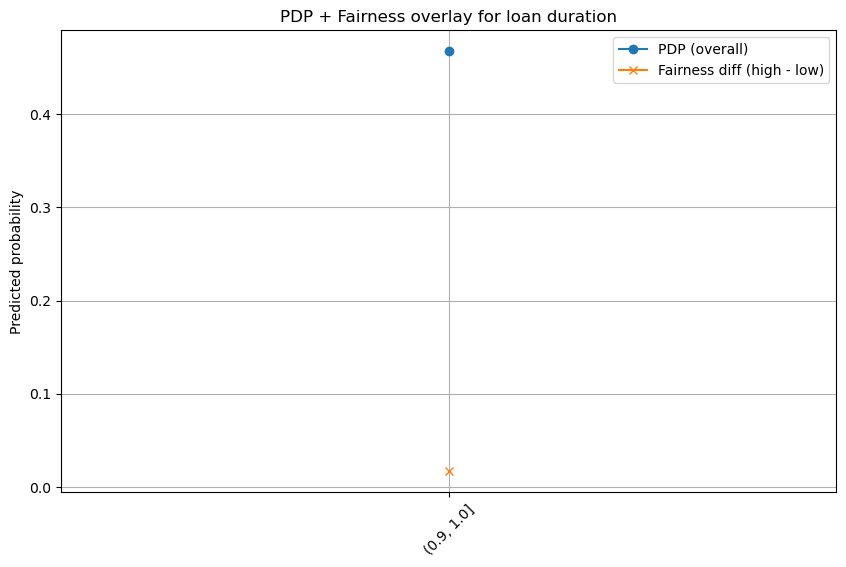

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

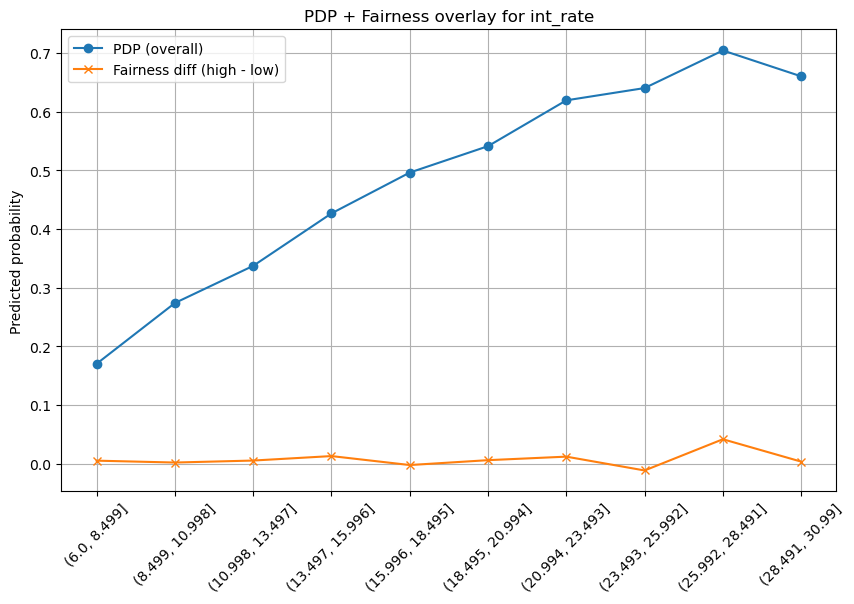

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

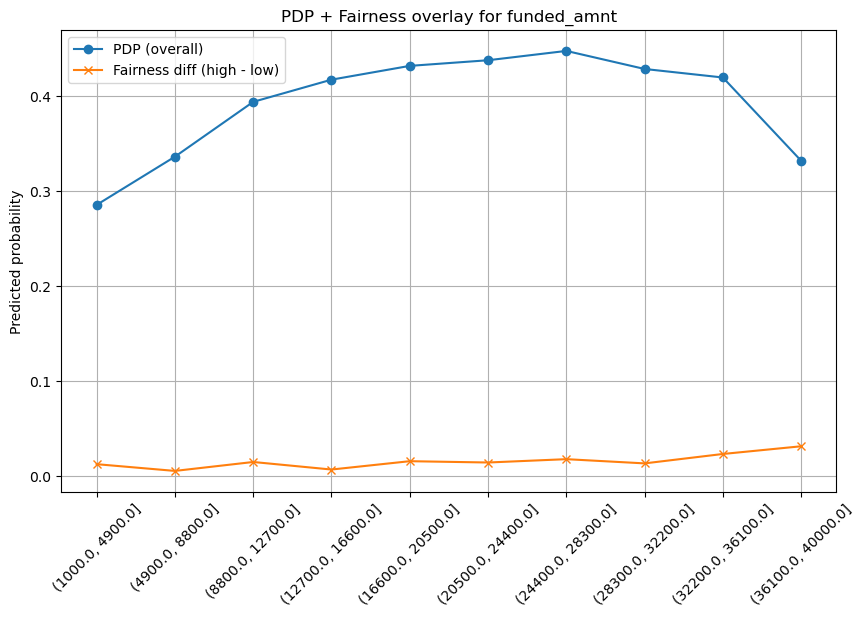

C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = np.where(data[protected_col] >= median_val, 'high_afro', 'low_afro')
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[feature], bins)
C:\Users\sheet\AppData\Local\Temp\ipykernel_33800\3021960267.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

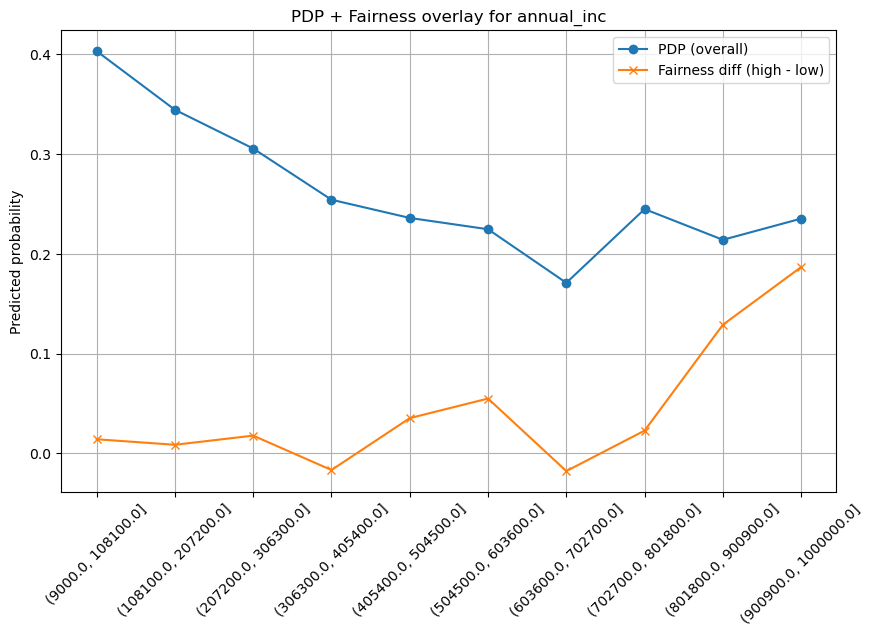

In [36]:
numeric_features = ['loan duration', 'int_rate', 'funded_amnt', 'annual_inc']


for feature in numeric_features:
    plot_fpdp(test_data, feature)


In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34198 entries, 951469 to 985666
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               34198 non-null  int64         
 1   issue_d                  34198 non-null  datetime64[ns]
 2   loan duration            34198 non-null  int64         
 3   annual_inc               34198 non-null  float64       
 4   avg_cur_bal              34198 non-null  float64       
 5   bc_open_to_buy           34198 non-null  float64       
 6   bc_util                  34198 non-null  float64       
 7   delinq_2yrs              34198 non-null  float64       
 8   dti                      34198 non-null  float64       
 9   emp_length               34198 non-null  object        
 10  emp_title                34198 non-null  object        
 11  fico_range_high          34198 non-null  float64       
 12  funded_amnt              34198 